# Progetto per il corso Programmazione di Applicazioni Data Intensive

## Descizione del problema

Il progetto consiste nel risolvere il problema di riconoscere se una stanza è occupata oppure no attraverso dati ricevuti da alcuni sensori. In particolare i dati noti sono:

- Data in anno-mese-giorno ora:minuto:secondo.
- Temperatura della stanza, misurata in Celsius.
- Umidità relativa, riportata in percentuale.
- Illuminazione della camera, misurata in Lux.
- Quantità di CO2 presente nella stanza, misurata in parti per milione (ppm).
- Proporzione di umidità, quantità derivata da temperatura ed umidità relativa, misurata in $kg_{w}/kg_{da}$.
- Occupazione della camera, variabile binaria che indica se la stanza è effettivamente occupata oppure no.

Dettagli sulla raccolta dati sono disponibili nella pubblicazione originale _(Luis M. Candanedo, VÃ©ronique Feldheim; 2016)_.

La data è una stringa, l'occupazione è binaria. Tutte le altre variabili sono continue.

Il dataset è composto da 20560 istanze senza valori assenti. Tuttavia è stato diviso in tre set: uno di training e 2 di testing. 

- Il primo, che verrà usato per addestrare e valutare i modelli, contiene 8143 istanze ed ha il 79% di istanze che rappresentano la classe non occupata. 
- Il secondo, che verrà usato per testare il modello finale, contiene 2665 istanze leggermente più bilanciate (64% della classe non occupata) ed è stato estratto con le stesse condizioni ambientali rispetto al set di training.
- Il terzo, invece, contiene 9752 istanze, ha la stessa distribuzione del primo set ma le variabili sono state misurate in condizioni diverse. Infatti la porta della stanza è stata lasciata aperta mentre era sempre chiusa nelle misurazioni fatte per i primi due insiemi.

## Inizializzazione e caricamento dati

Le seguenti celle inizializzano il notebook e caricano i dati.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Costanti

Queste costanti sono definite qui per organizzazione del codice ma verranno usate successivamente. RANDOM_STATE è il seed per tutte le operazioni che usano random, in modo da avere risultati riproducibili, mente DEFAULT_Z verrà usata per calcolare gli intervalli di confidenza al 95% come richiesto dalla consegna.

In [2]:
RANDOM_STATE = 42
DEFAULT_Z = 1.96 # 95% confidence

In [65]:
import os
import urllib.request
import zipfile

if not os.path.exists("dataset"):
    os.makedirs("dataset")
if not os.path.exists(os.path.join("dataset", "datatraining.txt")):
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip"
    urllib.request.urlretrieve(url, "data.zip")
    zip_ref = zipfile.ZipFile("data.zip", 'r')
    zip_ref.extractall("dataset")
    zip_ref.close()
    os.remove("data.zip")
    

occupancy_dataset = pd.read_csv(os.path.join("dataset", "datatraining.txt"))
occupancy_dataset_test = pd.read_csv(os.path.join("dataset", "datatest.txt"))
occupancy_dataset_test2 = pd.read_csv(os.path.join("dataset", "datatest2.txt"))

### Scelta indice

Scelgo di impostare la data come indice dei dataframe perché ha un valore distinto per ogni riga.

Informazioni estratte dalla data potrebbero essere usate come feature aggiuntive, come indicato da _(Luis M. Candanedo, VÃ©ronique Feldheim; 2016)_. Tuttavia non erano state riportate nel dataset originale quindi ho provato ad addestrare i miei modelli senza di esse. Avrei deciso di costruire queste feature se non fossi riuscito ad ottenere un risultato soddisfacente ma come si vedrà in seguito non sono necessarie.

In [4]:
occupancy_dataset.set_index(["date"], inplace=True)
occupancy_dataset_test.set_index(["date"], inplace=True)
occupancy_dataset_test2.set_index(["date"], inplace=True)

Per convenienza definisco una variabile in cui salvo il nome della colonna che continene il target della classificazione.

In [5]:
target = "Occupancy"

In [6]:
def reorder_dataset(dataset):
    tmp = dataset.drop([target], axis=1)
    tmp[target] = dataset[target]
    return tmp
occupancy_dataset = reorder_dataset(occupancy_dataset)
occupancy_dataset_test = reorder_dataset(occupancy_dataset_test)
occupancy_dataset_test2 = reorder_dataset(occupancy_dataset_test2)

Come ultimo passo dell'inizializzazione unisco i dataframe in uno per esplorare le variabili dell'intero dataset.

In [7]:
full_dataset = pd.concat([occupancy_dataset, occupancy_dataset_test, occupancy_dataset_test2])

L'occupazione in memoria del dataset non è onerosa. Posso mantenerlo tutto senza incorrere in problemi.

In [8]:
full_dataset.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 2015-02-04 17:51:00 to 2015-02-18 09:19:00
Data columns (total 6 columns):
Temperature      20560 non-null float64
Humidity         20560 non-null float64
Light            20560 non-null float64
CO2              20560 non-null float64
HumidityRatio    20560 non-null float64
Occupancy        20560 non-null int64
dtypes: float64(5), int64(1)
memory usage: 2.4 MB


## Analisi esplorativa dei dati

Inizio analizzando il dataset nell'interezza, confermando le statistiche riportate nella pubblicazione. 

Dall'analisi si nota che le variabili sono molto diverse tra di loro. 

- La temperatura va da un minimo di 19 ad un massimo di 24.408333. Questa variabile ha una bassa varianza ed è definita in un intervallo molto ristretto.
- L'umidità va da un minimo di 16.745 ad un massimo di 39.5 e la sua deviazione standard è quasi cinque volte quella della temperatura.
- La luminosità va da 0 a 1697.25 con una deviazione standard più di 200 volte quella della temperatura. Questa variabile sembra avere l'intervallo di valori più ampio di tutte.
- La quantità di CO2, similmente alla luce, arriva alle migliaia, però ha un minimo di 412.75. Questa è la variabile con deviazione standard maggiore di tutte, oltre a 300 volte la deviazione standard della temperatura.
- Il rapporto di umidità è, al contrario, la variabile con valori più piccoli e ristretti in distanza. Va da un minimo di 0.002674 ad un massimo di 0.006476.
- L'occupazione, ovviamente, va da 0 ad 1.

Queste statistiche dimostrano che gli attributi del dataset sono fortemente non normalizzati, il che suggerisce che una standardizzazione potrebbe essere necessaria per apprendere un modello su questi dati.

Sotto alla tabella che descrive il dataset completo riporto le statistiche calcolate per i tre set discussi sopra. Si può vedere che i dati sono leggermente diversi ma le variazioni non sono mai estreme.

Per esplorare meglio queste feature, nelle celle successive esamino in dettaglio gli istogrammi di ciascuna.

In [9]:
full_dataset.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


In [10]:
occupancy_dataset.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [11]:
occupancy_dataset_test.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000,2665.000000
mean,21.433876,25.353937,193.227556,717.906470,0.004027,0.364728
std,1.028024,2.436842,250.210906,292.681718,0.000611,0.481444
min,20.200000,22.100000,0.000000,427.500000,0.003303,0.000000
25%,20.650000,23.260000,0.000000,466.000000,0.003529,0.000000
50%,20.890000,25.000000,0.000000,580.500000,0.003815,0.000000
75%,22.356667,26.856667,442.500000,956.333333,0.004532,1.000000
max,24.408333,31.472500,1697.250000,1402.250000,0.005378,1.000000


In [12]:
occupancy_dataset_test2.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000,9752.000000
mean,21.001768,29.891910,123.067930,753.224832,0.004589,0.210111
std,1.020693,3.952844,208.221275,297.096114,0.000531,0.407408
min,19.500000,21.865000,0.000000,484.666667,0.003275,0.000000
25%,20.290000,26.642083,0.000000,542.312500,0.004196,0.000000
50%,20.790000,30.200000,0.000000,639.000000,0.004593,0.000000
75%,21.533333,32.700000,208.250000,831.125000,0.004998,0.000000
max,24.390000,39.500000,1581.000000,2076.500000,0.005769,1.000000


Definisco alcune funzioni di utilità per studiare gli attributi del dataset.

In [13]:
def study_attribute(dataset, attribute):
    if dataset[attribute].dtype == np.float:
        dataset[attribute].plot.hist()
        plt.xlabel(attribute)
        plt.show()
    else:
        dataset[attribute].value_counts().sort_index().plot.pie()
        plt.show()
        dataset[attribute].value_counts().sort_index().plot.bar()
        plt.xlabel(attribute)
        plt.show()

In [14]:
def correlation_plot(dataset, attr1, attr2):
    plt.scatter(dataset[attr1], dataset[attr2], c=dataset[target].values, cmap=plt.cm.coolwarm)
    plt.xlabel(attr1)
    plt.ylabel(attr2)
    plt.show()

### Analisi distribuzione del target

Esplorando la distribuzione del target si nota come le due classi sono sbilanciate, il che può trarre in inganno la valutazione delle performance di un modello, specialmente se si usano metriche come l'accuratezza. Durante la ricerca del modello migliore terrò conto di questo dettaglio.

Lo sbilanciamento si ripete anche nel tre sottoinsiemi dei dati, come era indicato dagli autori del dataset.

In [15]:
full_dataset[target].value_counts()

0    15810
1     4750
Name: Occupancy, dtype: int64

In [16]:
full_dataset[target].value_counts(normalize=True)

0    0.768969
1    0.231031
Name: Occupancy, dtype: float64

In [17]:
occupancy_dataset[target].value_counts(normalize=True)

0    0.78767
1    0.21233
Name: Occupancy, dtype: float64

In [18]:
occupancy_dataset_test[target].value_counts(normalize=True)

0    0.635272
1    0.364728
Name: Occupancy, dtype: float64

In [19]:
occupancy_dataset_test2[target].value_counts(normalize=True)

0    0.789889
1    0.210111
Name: Occupancy, dtype: float64

### Analisi della distribuzione degli attributi

Lo studio degli attributi permette di fare le seguenti osservazioni:
- La temperatura è principalmente tra 20 e 21 gradi, quindi la media è molto vicina al minimo.
- L'umidità ha una distribuzione più uniforme della temperatura ed il picco di valori più frequenti è più centrale.
- La luminosità è estremamente concentrata vicino allo zero. La prima colonna dell'istogramma è più alta di tutte le altre messe insieme. Questo suggerisce che una binarizzazione della variabile potrebbe mantenere il significato della variabile.
- Similmente alla luminosità, l'attributo che rappresenta la CO2 ha un'alta concentrazione di valori bassi, attorno a 500. Anche questa variabile, quindi potrebbe essere binarizzata.
- L'unica variabile categorica del dataset è il target della classificazione. I grafici mostrano lo sbilanciamento di classi di cui si è già parlato sopra.

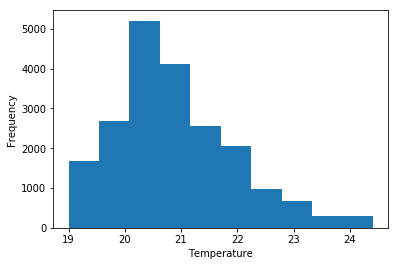

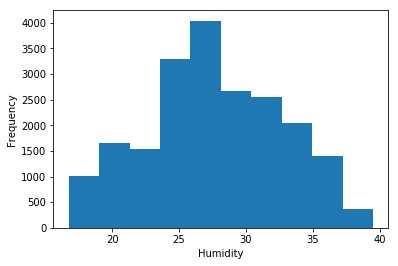

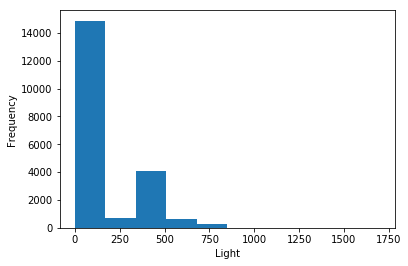

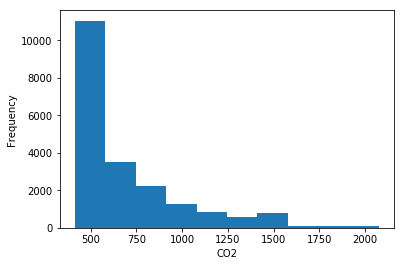

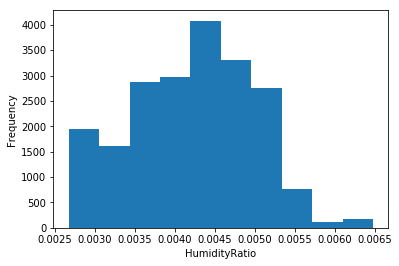

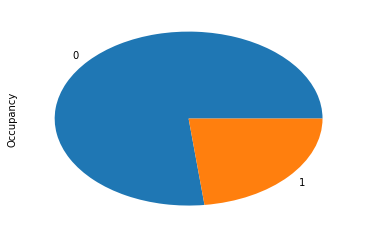

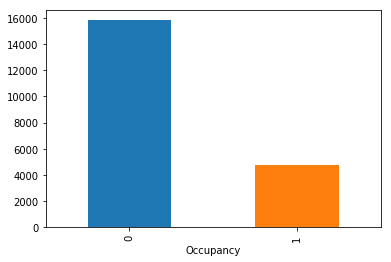

In [20]:
for attribute in occupancy_dataset.columns:
    study_attribute(full_dataset, attribute)

### Analisi della correlazione tra gli attributi

Dopo aver esplorato le distribuzioni dei dati, studio la correlazione tra le colonne del dataset. Per farlo costruisco una matrice di correlazione. Per comprenderla più facilmente riporto anche una matrice di booleani che indica solo se la correlazione tra due attributi è abbastanza grande in modulo (ho scelto 0.5 come soglia).

La matrice di correlazione mostra una forte dipendenza tra l'occupazione e la luminosità, il che ha senso visto che di solito le persone lasciano accendono la luce quando entrano in una stanza e la spengono quando escono.
Similmente anche la quantità di CO2 sembra correlarsi molto con l'occupazione ed effettivamente ci si aspetta che la quantità di CO2 aumenti se c'è una persona nella stanza che respiri.
Inoltre notiamo che la temperatura ha una correlazione di più di 0.5 con l'occupazione della stanza, possibilmente dovuta all'uso di riscaldamenti.

Tra gli attributi si nota un'altissima correlazione tra umidità e proporzione di umidità, il che è da aspettarsi visto che la seconda è derivata dalla prima. Mi aspetto che un modello con regolarizzazione l1 ignori una delle due variabili.

Anche temperatura e luminosità hanno un'alta correlazione positiva fra loro. Questo può essere in parte una conseguenza della correlazione di entrambe le variabili con l'occupazione come discusso sopra ed in parte dovuto al fatto che le lampadine tendono ad emettere calore.

Altre correlazioni si trovano tra CO2 e proporzione di umidità, temperatura e CO2 e tra luminosità e CO2 ma il modulo di queste correlazioni è inferiore a 0.5.

L'umidità è la variabile con correlazione minore all'occupazione della stanza, mi aspetto che questa variabile non abbia un ruolo importante nella classificazione.

Nessuna correlazione negativa sembra essere particolarmente rilevante, in particolare tutte le variabili sembrano contribuire positivamente alla presenza di una persona nella stanza.

In [21]:
full_dataset.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000


In [22]:
abs(full_dataset.corr()) > 0.5

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,True,False,True,False,False,True
Humidity,False,True,False,False,True,False
Light,True,False,True,False,False,True
CO2,False,False,False,True,False,True
HumidityRatio,False,True,False,False,True,False
Occupancy,True,False,True,True,False,True


### Grafici di correlazione

Esploro meglio la correlazione tra le variabili riportando i grafici a dispersione per tutte le coppie di attributi. I punti sono colorati in base alla classe di appartenenza (blu indica stanza non occupata, rosso indica stanza occupata).

I grafici mostrano dettagli interessanti:

- I grafici che includono la luce come uno dei due assi sembrano essere tutti quasi linearmente separabili. Quindi mi aspetto che i modelli sfruttino questa proprietà della luminosità.
- Umidità e proporzione di umidità non sembrano dare informazioni utili per separare le due classi.
- Nessuno dei grafici è completamente linearmente separabile, seppure sembra possibile ottenere buoni risultati con una retta su alcuni di questi grafici a dispersione, mi aspetto che un modello che usi più di due attributi riesca ad avere risultati migliori di uno che ne usa solo due.

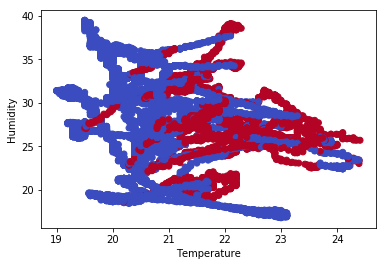

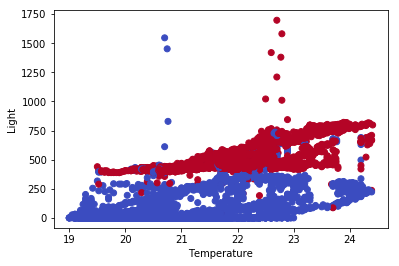

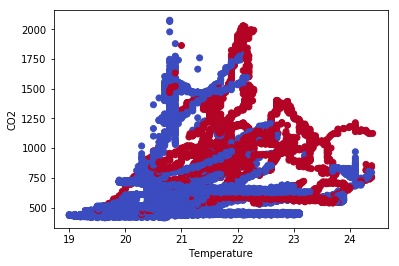

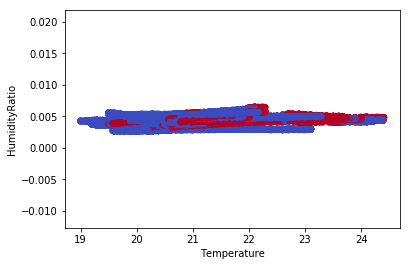

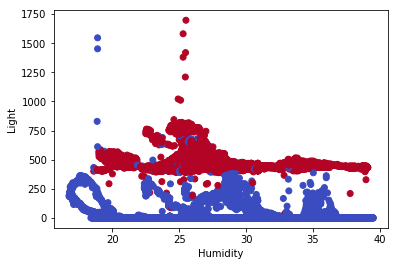

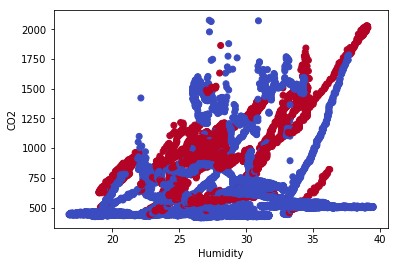

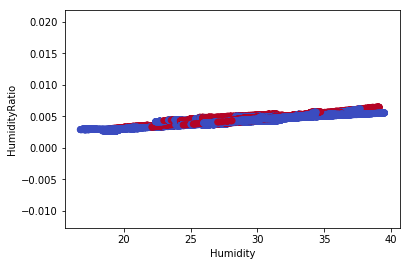

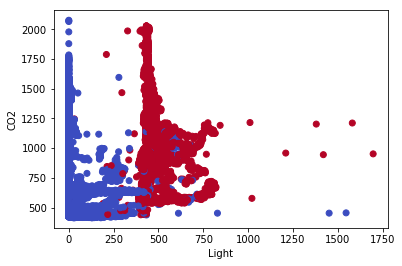

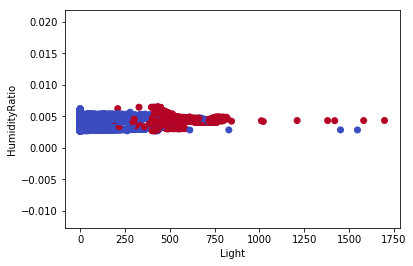

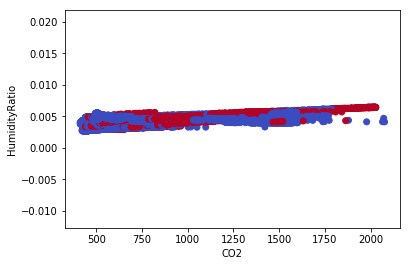

In [23]:
correlation_plot(full_dataset, "Temperature", "Humidity")
correlation_plot(full_dataset, "Temperature", "Light")
correlation_plot(full_dataset, "Temperature", "CO2")
correlation_plot(full_dataset, "Temperature", "HumidityRatio")
correlation_plot(full_dataset, "Humidity", "Light")
correlation_plot(full_dataset, "Humidity", "CO2")
correlation_plot(full_dataset, "Humidity", "HumidityRatio")
correlation_plot(full_dataset, "Light", "CO2")
correlation_plot(full_dataset, "Light", "HumidityRatio")
correlation_plot(full_dataset, "CO2", "HumidityRatio")

## Binarizzazione

Seguendo l'intuizione avuta osservando gli istogrammi della luminosità e della CO2 esamino cosa cambia nel dataset binarizzando questi due attributi.

Usando gli istogrammi definisco delle soglie di binarizzazione, trasformo le colonne e, infine, ricalcolo la matrice di correlazione aggiungendo i nuovi attributi binari.

Il risultato è che per la luminosità la variabile binarizzata è molto meno correlata con l'occupazione mentre per la CO2 ottengo un leggero aumento di correlazione usando la nuova variabile. 

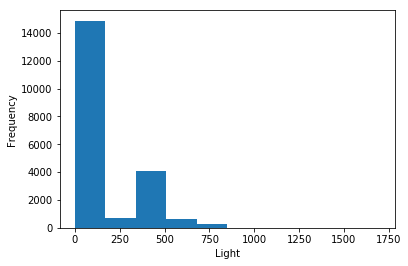

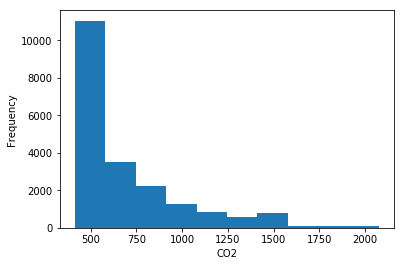

In [24]:
study_attribute(full_dataset, "Light")
study_attribute(full_dataset, "CO2")

In [25]:
from sklearn.preprocessing import Binarizer

transformed_dataset = full_dataset.copy()
light_binarizer = Binarizer(threshold=0.0)
binary_light = light_binarizer.transform(pd.DataFrame(transformed_dataset["Light"]))
CO2_binarizer = Binarizer(threshold=600.0)
binary_CO2 = CO2_binarizer.transform(pd.DataFrame(transformed_dataset["CO2"]))
transformed_dataset["binary_light"] = pd.DataFrame(binary_light, index=transformed_dataset.index)[0].astype('int32')
transformed_dataset["binary_CO2"] = pd.DataFrame(binary_CO2, index=transformed_dataset.index)[0].astype('int32')

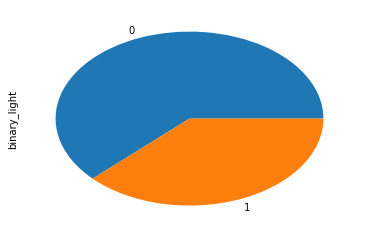

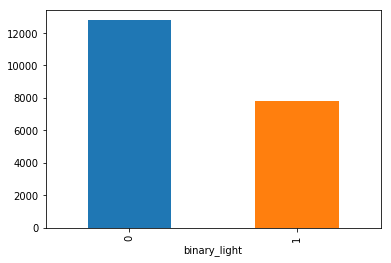

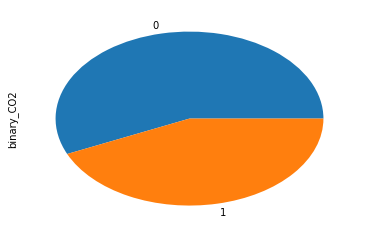

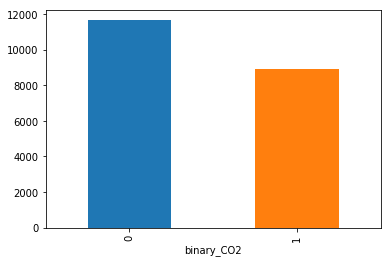

In [26]:
study_attribute(transformed_dataset, "binary_light")
study_attribute(transformed_dataset, "binary_CO2")

In [27]:
transformed_dataset.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,binary_light,binary_CO2
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610,0.586726,0.504898
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240,0.029521,0.153557
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850,0.795758,0.505245
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582,0.335830,0.746214
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324,0.240979,0.342544
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000,0.701698,0.508357
binary_light,0.586726,0.029521,0.795758,0.335830,0.240979,0.701698,1.000000,0.413734
binary_CO2,0.504898,0.153557,0.505245,0.746214,0.342544,0.508357,0.413734,1.000000


## Standardizzazione

Esamino il dataset con le feature standardizzate e riporto i grafi di correlazioni dopo la standardizzazione. 

In particolare quest'operazione permette di vedere meglio l'effetto di variabili con intervalli piccoli come la proporzione di umidità.

In [28]:
from sklearn.preprocessing import StandardScaler

scaled_dataset = transformed_dataset.drop(["binary_light", "binary_CO2", target], axis=1)
scaler = StandardScaler()
scaler.fit_transform(scaled_dataset)
scaled_dataset = pd.DataFrame(scaler.transform(scaled_dataset), columns=scaled_dataset.columns, index=scaled_dataset.index)
scaled_dataset["binary_light"] = transformed_dataset["binary_light"]
scaled_dataset["binary_CO2"] = transformed_dataset["binary_CO2"]
scaled_dataset[target] = transformed_dataset[target]
scaled_dataset.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,binary_light,binary_CO2,Occupancy
count,2.056000e+04,2.056000e+04,2.056000e+04,2.056000e+04,2.056000e+04,20560.000000,20560.000000,20560.000000
mean,1.896624e-15,3.317709e-17,-5.529515e-18,2.211806e-16,-5.418925e-16,0.378794,0.433268,0.231031
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,0.485098,0.495539,0.421503
min,-1.806342e+00,-2.190055e+00,-6.213908e-01,-8.927021e-01,-2.024076e+00,0.000000,0.000000,0.000000
25%,-6.692123e-01,-6.334613e-01,-6.213908e-01,-7.408674e-01,-6.632705e-01,0.000000,0.000000,0.000000
50%,-1.954084e-01,-7.344890e-02,-6.213908e-01,-4.021181e-01,8.280323e-02,0.000000,0.000000,0.000000
75%,5.863681e-01,7.294363e-01,8.090425e-01,3.666957e-01,7.858972e-01,1.000000,1.000000,0.000000
max,3.318637e+00,2.377358e+00,7.444399e+00,4.453646e+00,2.927262e+00,1.000000,1.000000,1.000000


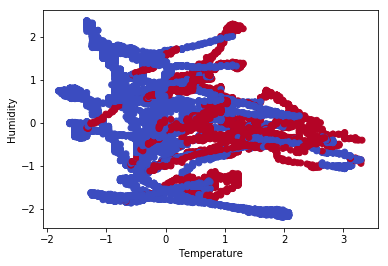

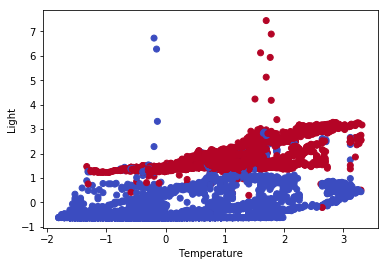

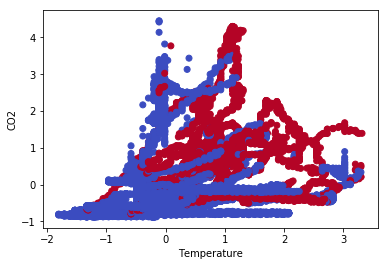

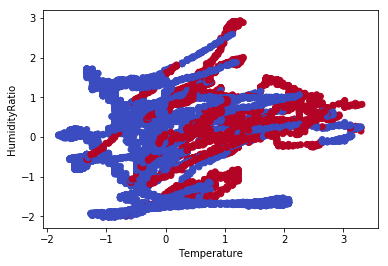

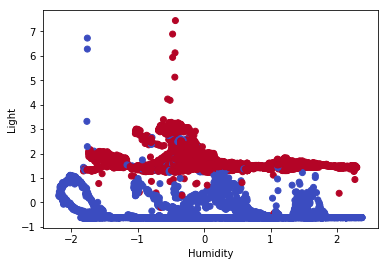

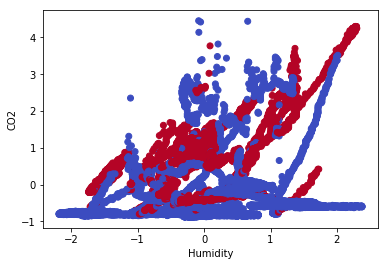

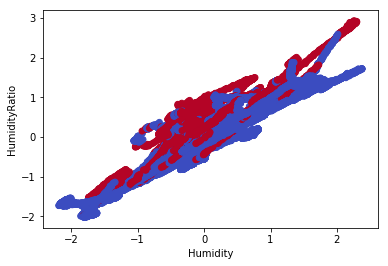

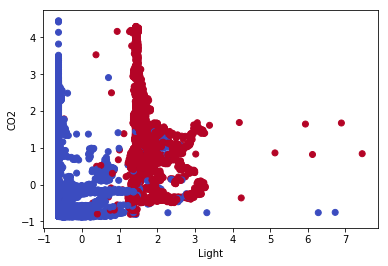

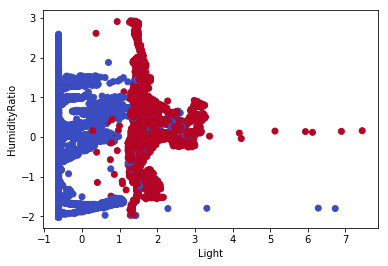

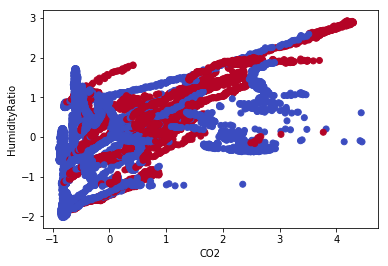

In [29]:
correlation_plot(scaled_dataset, "Temperature", "Humidity")
correlation_plot(scaled_dataset, "Temperature", "Light")
correlation_plot(scaled_dataset, "Temperature", "CO2")
correlation_plot(scaled_dataset, "Temperature", "HumidityRatio")
correlation_plot(scaled_dataset, "Humidity", "Light")
correlation_plot(scaled_dataset, "Humidity", "CO2")
correlation_plot(scaled_dataset, "Humidity", "HumidityRatio")
correlation_plot(scaled_dataset, "Light", "CO2")
correlation_plot(scaled_dataset, "Light", "HumidityRatio")
correlation_plot(scaled_dataset, "CO2", "HumidityRatio")

## Individuazione delle feature più rilevanti

Per studiare quali feature siano più rilevanti creo un modello che usa la regolarizzazione con norma L1 e lo addestro su tutte le feature. Poi esamino i coefficienti appresi da questo modello per stabilire quali feature ha utilizzato.

Uso un semplice modello di regressione logistica ed applico la standardizzazione delle feature per evitare che attributi con alti valori prevalgano sugli altri.

Calcolo anche l'accuratezza del modello sul test set per assicurarmi che è stato appreso un modello sensato, altrimenti l'analisi delle feature rilevanti non porterebbe a nulla di significativo.

In questo caso l'accuratezza è molto alta, quindi non c'è problema.

In [30]:
X_train = occupancy_dataset.drop([target], axis=1)
y_train = occupancy_dataset[target]
X_val = occupancy_dataset_test.drop([target], axis=1)
y_val = occupancy_dataset_test[target]

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(penalty="l1", C=0.005, random_state=RANDOM_STATE))
])
log_reg_model.fit(X_train, y_train)
log_reg_model.score(X_val, y_val)

0.9782363977485928

In [32]:
coefs = pd.DataFrame(log_reg_model.named_steps["model"].coef_)
coefs.columns = X_train.columns
coefs

,Temperature,Humidity,Light,CO2,HumidityRatio
0,0.0,0.0,1.953836,0.574452,0.0


### Analisi delle feature rilevanti

L'analisi dei coefficienti mostra che soltanto la luminosità e la CO2 hanno partecipato alla definizione del decision boundary.

Stavolta riduco la regolarizzazione ed uso L2, sempre mantenendo la regressione logistica come modello.

Addestro lo stesso modello prima con tutte le feature e poi solo con le due rilevate sopra ed osservo la differenza. Nel primo caso ottiene un'accuratezza leggermente migliore mentre nel secondo ha la stessa del modello addestrato con L1.

Osservando i coefficienti noto che entrambi i modelli usano pesi molto maggiori per la luminosità ed il CO2 ed i loro valori sono molto simili confrontando i due modelli. Il primo, però, pone una leggera enfasi sulla temperatura. Invece l'umidità ed il rapporto di umidità hanno i coefficienti più bassi, come previsto studiando la correlazione.

In [33]:
relevant_only_train = X_train[["Light", "CO2"]]
relevant_only_val = X_val[["Light", "CO2"]]

In [34]:
log_reg_model2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(C=0.01, random_state=RANDOM_STATE))
])

In [35]:
log_reg_model2.fit(X_train, y_train)
log_reg_model2.score(X_val, y_val)

0.9786116322701689

In [36]:
coefs = pd.DataFrame(log_reg_model2.named_steps["model"].coef_)
coefs.columns = X_train.columns
coefs

,Temperature,Humidity,Light,CO2,HumidityRatio
0,-0.190812,0.01373,1.960377,0.91593,0.013937


In [37]:
log_reg_model2.fit(relevant_only_train, y_train)
log_reg_model2.score(relevant_only_val, y_val)

0.9782363977485928

In [38]:
pd.DataFrame(log_reg_model2.named_steps["model"].coef_, columns = relevant_only_train.columns)

,Light,CO2
0,1.874843,0.885516


### Decision boundary nel grafico delle feature rilevanti

Visto che il secondo modello usa solo due attributi posso visualizzare il decision boundary in un grafico. Nella cella di sotto costruisco l'output del modello e lo confronto con il grafico a dispersione dei dati di validazione. Si vede come la luminosità sembra essere il fattore decisivo nell'assegnamento della classe, se è abbastanza alta nessun punto è classificato come non occupato. Ma a valori di luminosità bassa il modello sceglie in base a valori di CO2 alta.

In [39]:
def make_meshgrid(x, y, h=1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [40]:
def decision_boundary(model, attr1, attr2):    
    fig, ax = plt.subplots()
    X0, X1 = X_val[attr1].values, X_val[attr2].values
    xx, yy = make_meshgrid(X0, X1)

    ax.scatter(X0, X1, c=y_val.values, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)

    ax.set_xlabel(attr1)
    ax.set_ylabel(attr2)
    plt.show()

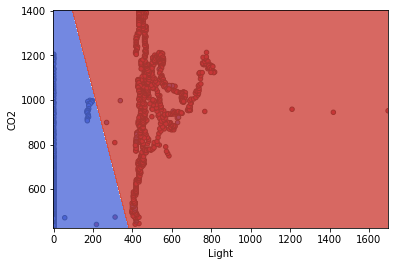

In [41]:
decision_boundary(log_reg_model2, "Light", "CO2")

### Analisi delle feature rilevanti con binarizzazione 

Testo ora come cambia l'analisi delle feature importanti usando la binarizzazione per la variabile di CO2.

Come atteso il modello con L1 mette più peso alla versione binarizzata di CO2 che all'attributo di CO2 stesso, tuttavia sceglie di non azzerare il contributo della variabile di CO2 nonostante la forte regolarizzazione che ho applicato.

Addestrando il modello con regolarizzazione L2 con tutte le feature precedenti ed in aggiunta la CO2 binarizzata sorprendentemente ha un risultato persino peggiore dell'addestramento con solo le feature originali. Rimuovendo tutte le feature tranne luminosità, CO2 e CO2 binarizzata si ottiene un'accuratezza ancora più bassa.

Questi risultati mi suggeriscono che la binarizzazione dell'attributo CO2, seppur sembrava promettente dall'analisi della matrice di correlazione, conviene invece non usarla.

In [42]:
binary_CO2 = CO2_binarizer.transform(pd.DataFrame(X_train["CO2"]))
X_train_transformed = X_train.copy()
X_train_transformed["binary_CO2"] = pd.DataFrame(binary_CO2, index=X_train.index)[0].astype('int32')

binary_CO2 = CO2_binarizer.transform(pd.DataFrame(X_val["CO2"]))
X_val_transformed = X_val.copy()
X_val_transformed["binary_CO2"] = pd.DataFrame(binary_CO2, index=X_val.index)[0].astype('int32')

In [43]:
log_reg_model.fit(X_train_transformed, y_train)
log_reg_model.score(X_val_transformed, y_val)

0.9782363977485928

In [44]:
pd.DataFrame(log_reg_model.named_steps["model"].coef_, columns = X_train_transformed.columns)

,Temperature,Humidity,Light,CO2,HumidityRatio,binary_CO2
0,0.0,0.0,1.846647,0.271869,0.0,0.402986


In [45]:
log_reg_model2.fit(X_train_transformed, y_train)
log_reg_model2.score(X_val_transformed, y_val)

0.9782363977485928

In [46]:
relevant_only_train_transformed = X_train_transformed[["Light", "CO2", "binary_CO2"]]
relevant_only_val_transformed = X_val_transformed[["Light", "CO2", "binary_CO2"]]

In [47]:
log_reg_model2.fit(relevant_only_train_transformed, y_train)
log_reg_model2.score(relevant_only_val_transformed, y_val)

0.973358348968105

## Grid search con nested cross fold validation

In questa sezione effettuo una ricerca più estesa tra i possibili iperparametri dei modelli e modelli stessi. Per farlo userò una grid search sui seguenti parametri:
- Uso della standardizzazione oppure no.
- Perceptron o regressione logistica (per fare questo non era possibile usare la stessa griglia per via di parametri diversi quindi faccio un confronto manuale tra i migliori dei due dopo aver fatto grid search separate per entrambi).
- Coefficiente della regolarizzazione tra [0.001, 0.01, 0.1, 1, 10, 100, 1000]
- Regolarizzazione L1 oppure L2.
- Bilanciamento delle classi nella funzione di loss oppure no.

Ricordando il problema dello sbilanciamento delle classi, uso la f1-measure per confrontare i modelli durante il grid search invece dell'accuratezza.

La grid search viene fatta nel passo interno di un nested cross validation con k = 3 per il cv esterno e k = 5 per quello interno. I fold interni vengono usati per fare il grid search sui parametri, mentre addestro i modelli sui rispettivi fold esterni per stimare l'accuratezza a regime.

In questo modo ottengo 3 modelli addestrati su fold diversi del training set.

Prima di confrontare i modelli calcolo e stampo i rusultati che i tre modelli ottengono nei rispettivi fold di validazione: matrice di confusione, accuratezza, precisione, recall, f1-measure sulle singole classi e f1 measure aggregata con media macro.

Inoltre calcolo l'intervallo di accuratezza a regime con confidenza al 95% come richiesto dalla consegna.

Infine confronto l'accuratezza dei tre modelli tra di loro, trovando l'intervallo della differenza tra i due errori e controllando se includa lo 0 oppure no.

In questo problema risulta che tutti i modelli calcolati hanno lo 0 nell'intervallo quindi sono statisticamente equivalenti con confidenza al 95%.

In [48]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import Perceptron

perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(random_state=RANDOM_STATE))
])

log_reg_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  LogisticRegression(random_state=RANDOM_STATE))
])

log_reg_grid = {
    "scaler": [None, StandardScaler()],
    "model__C": np.logspace(-3, 3, 7),
    "model__class_weight": [None, "balanced"],
    "model__penalty": ["l1", "l2"]
}

perceptron_grid = {
    "scaler": [None, StandardScaler()],
    "model__alpha": np.logspace(-3, 3, 7),
    "model__class_weight": [None, "balanced"],
    "model__penalty": ["l1", "l2"]
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [50]:
def calc_scores(y_val, y_pred):
    return {
        "accuracy": accuracy_score(y_true=y_val, y_pred=y_pred),
        "precision": precision_score(y_true=y_val, y_pred=y_pred),
        "recall": recall_score(y_true=y_val, y_pred=y_pred),
        "confusion_matrix": confusion_matrix(y_true=y_val, y_pred=y_pred),
        "f1_score": f1_score(y_true=y_val, y_pred=y_pred, average=None),
        "f1_score_macro": f1_score(y_true=y_val, y_pred=y_pred, average="macro")
    }

In [51]:
# all_nested = []
# best_nested = []

params = []
models = []
outer_scores = []
val_n = []

for train, val in outer_cv.split(X_train.values, y_train.values):
    # gs = GridSearchCV(model, grid, cv=inner_cv, scoring="f1")
    gs_log_reg = GridSearchCV(log_reg_model, log_reg_grid, cv=inner_cv, scoring="f1")
    gs_log_reg.fit(X_train.values[train], y_train.values[train])
    
    gs_perceptron = GridSearchCV(perceptron_model, perceptron_grid, cv=inner_cv, scoring="f1")
    gs_perceptron.fit(X_train.values[train], y_train.values[train])
    
    if gs_log_reg.best_score_ > gs_perceptron.best_score_:
        best = gs_log_reg
    else: 
        best = gs_perceptron
    
    val_n.append(len(val))
    
    models.append(best.best_estimator_)
    params.append(best.best_params_)
    
    est = best.best_estimator_
    est.fit(X_train.values[train], y_train.values[train])
    
    outer_scores.append(calc_scores(y_val=y_train.values[val], y_pred=est.predict(X_train.values[val])))
    
    # all_nested.append(pd.DataFrame(gs.cv_results_))
    # best_nested.append(pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(1))
# all_nested = pd.concat(all_nested)
# best_nested = pd.concat(best_nested)

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\me

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\me

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\li

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stocha

c:\program files\python35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not Non

c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
c:\program files\python35\lib\site-packages\sklearn\me

In [52]:
import math

def accuracy_confidence(accuracy, N, Z=DEFAULT_Z):
    tmp1 = 2 * N * accuracy + Z * Z
    tmp2 = Z * math.sqrt(Z * Z + 4 * N * accuracy - 4 * N * accuracy * accuracy)
    den = 2 * (N + Z * Z)
    return ((tmp1 - tmp2) / den, (tmp1 + tmp2) / den)

def model_comparison(accuracy1, accuracy2, n1, n2, Z=DEFAULT_Z):
    # assume error = misclassifications = 1 - accuracy
    e1 = 1 - accuracy1
    e2 = 1 - accuracy2
    d = abs(e2 - e1)
    sigma_sq = e1 * (1 - e1) / n1 + e2 * (1 - e2) / n2
    sigma = math.sqrt(sigma_sq)
    return (d - Z * sigma, d + Z * sigma)
def check_interval(interval):
    if interval[1] > 0 and interval[0] < 0:
        print("The difference is not statistically significant with this confidence")
    else:
        print("The difference is statistically significant with this confidence")

In [53]:
for i, model1 in enumerate(models):
    if "model__C" in params[i]:
        print("model {} is a LogisticRegression model with parameters: {}".format(i, params[i]))
    else:
        print("model {} is a Perceptron model with parameters: {}".format(i, params[i]))
    
    print("confusion matrix:")
    print(pd.DataFrame(outer_scores[i]["confusion_matrix"]))
    print("accuracy_score: {}".format(outer_scores[i]["accuracy"]))
    print("precision_score: {}".format(outer_scores[i]["precision"]))
    print("recall_score: {}".format(outer_scores[i]["recall"]))
    
    print("f1_score:") 
    print(pd.Series(outer_scores[i]["f1_score"]))
    print("f1_score macro avarage: {}".format(outer_scores[i]["f1_score_macro"]))
    
    print("accuracy interval with 95% confidence: {}".format(accuracy_confidence(outer_scores[i]["accuracy"], val_n[i])))

    print("")
    
    for j in range(0, i):
        interval = model_comparison(outer_scores[i]["accuracy"], outer_scores[j]["accuracy"], val_n[i], val_n[j])
        print("Comparison beetwen model {} and model {} with 95% confidence: {}".format(i, j, interval))
        check_interval(interval)
    print("")

model 0 is a LogisticRegression model with parameters: {'model__C': 10.0, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'scaler': None}
confusion matrix:
      0    1
0  2111   27
1     2  575
accuracy_score: 0.9893186003683241
precision_score: 0.9551495016611296
recall_score: 0.9965337954939342
f1_score:
0    0.993178
1    0.975403
dtype: float64
f1_score macro avarage: 0.9842904797733567
accuracy interval with 95% confidence: (0.9847017676441557, 0.9925526630663348)


model 1 is a LogisticRegression model with parameters: {'model__C': 100.0, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'scaler': None}
confusion matrix:
      0    1
0  2106   32
1     1  575
accuracy_score: 0.9878408253500368
precision_score: 0.9472817133443163
recall_score: 0.9982638888888888
f1_score:
0    0.992226
1    0.972105
dtype: float64
f1_score macro avarage: 0.9821654833342792
accuracy interval with 95% confidence: (0.9829735734222067, 0.9913289760714795)

Comparison beetwen model

## Scelta del modello e confronto con modello casuale

Siccome tutti e tre i modelli sono statisticamente equivalenti scelgo quello con regolarizzazione maggiore perché ha pesi più bassi e quindi più facili da interpretare.

Prima di interpretare la conoscenza appresa, confronto il modello con uno completamente casuale. Il modello dummy predirà la classe di un'istanza seguendo la distribuzione dei valori del target.

A questo punto addestro entrambi i modelli sull'intero set di training e li valuto sul primo test set. Poi confronto le loro f1-measure con confidenza del 99%.

Il risultato di questa analisi è che effettivamente il modello appreso non è statisticamente equivalente al modello casuale, come suggerisce la differenza sostanziale in accuratezza tra i due.

In [54]:
#chooce one indipendently of the others:
model = models[2]
model.fit(X_train, y_train)
model.score(X_val, y_val)

0.9782363977485928

In [55]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
dummy.score(X_val, y_val)

0.5831144465290806

In [56]:
Z_dummy = 2.58 # 99% confidence
f1_model = f1_score(y_true=y_val, y_pred=model.predict(X_val), average="macro")
f1_dummy = f1_score(y_true=y_val, y_pred=dummy.predict(X_val), average="macro")
dummy_interval = model_comparison(f1_model, f1_dummy, len(y_val), len(y_val), Z=Z_dummy)
print(dummy_interval)
check_interval(dummy_interval)

(0.45621361310973196, 0.5084062861097737)
The difference is statistically significant with this confidence


## Confronto con risultati ottenuti nell'articolo orginale

(Luis M. Candanedo, VÃ©ronique Feldheim; 2016) ha riportato diversi risultati su questo dataset, in particolare l'accuratezza che diversi modelli hanno ottenuto nei diversi dataset di testing.

In questa sezione confronto il mio modello con il migliore dei loro usando una confidenza del 95% per stabilire se ho ottenuto un risultato superiore.

Il loro modello dai risultati migliori usa altri due attributi derivati: secondi da mezzanotte ed un booleano che indica se è week-end. Il mio modello non fa utilizzo di queste informazioni perché non erano presenti direttamente nel dataset e non si sono rivelate necessarie ad ottenere risultati significativi.

Il confronto riporta in entrambi i casi un intervallo che include lo 0, quindi il mio modello è statisticamente equivalente a quello prodotto dagli autori con una confidenza del 95%.

In [57]:
my_acc_test1 = model.score(X_val, y_val)

In [58]:
X_test2 = occupancy_dataset_test2.drop([target], axis=1)
y_test2 = occupancy_dataset_test2[target]
my_acc_test2 = model.score(X_test2, y_test2)

In [59]:
# model = LDA, parameters = Temperature, Humidity, Light, CO2, Humidity, seconds from midnight, Week Status
their_best1 = 0.9790
their_best2 = 0.9933

interval1 = model_comparison(my_acc_test1, their_best1, len(X_val), len(X_val))
interval2 = model_comparison(my_acc_test2, their_best2, len(X_test2), len(X_test2))
print(interval1)
check_interval(interval1)
print(interval2)
check_interval(interval2)

(-0.0070033339276981705, 0.008530538430512465)
The difference is not statistically significant with this confidence
(-0.0022277299565469956, 0.0023634149442417797)
The difference is not statistically significant with this confidence


## Interpetazione della conoscenza

In quest'ultima sezione interpreto i pesi appresi dal modello. Per comodità riporto gli iperparametri trovati dal grid search e successivamente i coefficienti appresi nell'addestramento con l'interno training set.

Prima di tutto si può notare che il modello è molto semplice. Infatti non usa né standardizzazione, né pesi per moderare lo sbilanciamento tra classi.

Osservando quali attributi vengono usati, noto che solo la temperatura, la luminosità e la quantità di CO2 stanno venendo presi in considerazione per la scelta della classe.

Secondariamente i coefficienti sono molto bassi a differenza del primo modello che si affidava a pesi quasi 100 volte superiori. Questo probabilmente è dovuto alla mancanza di standardizzazione, infatti luminosità e CO2 hanno valori molto più alti della temperatura quindi non servono pesi altrettanto elevati.

Il segno dei pesi appresi indica che il modello assegna la classe _Occupato_ ad alti valori di luminosità e CO2 mentre alti valori di temperatura portano il modello maggiormente verso la classe _Non occupato_.

Per interpretare questo risultato faccio riferimento ai grafici di correlazione tra temperatura e luminosità e fra temperatura e CO2 ed addestro dei modelli che usano solo queste due variabili. In entrambi i casi noto come il decision boundary effettivamente indica che la temperatura viene usata con coefficiente negativo, specialmente nel caso di temperatura e CO2. Da questo traggo come conclusione che, nonostante da sola la temperatura sia positivamente correlata con l'occupazione della stanza, accoppiata a queste due variabili, specialmente CO2, è più utile ad indicare che la stanza non è occupata se le altre due variabili non sono sufficientemente alte.
Tornando alla matrice della correlazione ne traggo come conclusione che la correlazione tra temperatura e le altre due variabili porta il modello a sospettare che se la temperatura è alta ma gli altri due attributi sono bassi allora la stanza non è occupata.

In [60]:
params[2]

{'model__C': 0.01,
 'model__class_weight': None,
 'model__penalty': 'l1',
 'scaler': None}

In [61]:
pd.DataFrame(model.named_steps["model"].coef_, columns = X_train.columns)

,Temperature,Humidity,Light,CO2,HumidityRatio
0,-0.437972,0.0,0.018427,0.004289,0.0


In [62]:
X_temp_lum =  X_train[["Light", "Temperature"]]
X_temp_CO2 =  X_train[["CO2", "Temperature"]]

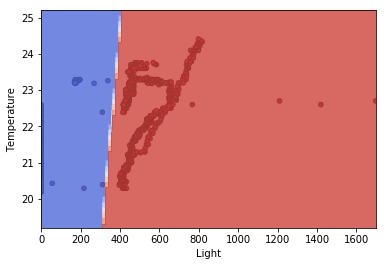

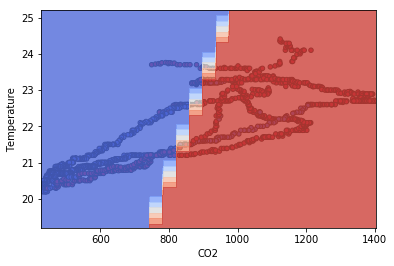

In [63]:
model.fit(X_temp_lum, y_train)
decision_boundary(model, "Light", "Temperature")

model.fit(X_temp_CO2, y_train)
decision_boundary(model, "CO2", "Temperature")

## Conclusione

Ho studiato il problema di classificazione presentato da (Luis M. Candanedo, VÃ©ronique Feldheim; 2016), interpretato le variabili del dataset e trovato le più significative attraverso regolarizzazione con norma L1. Ho trovato tre modelli statisticamente equivalenti con confidenza del 95% che risolvono questo problema. Per uno di questi modelli ha mostrato come esso fosse statisticamente equivalente al modello prodotto dagli autori del dataset e ne ho interpretato la conoscenza appresa.

## Fonti
1) Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, VÃ©ronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.